**Candidate Name**: Sneha Santha Prabakar

**Week 7.1: Improved Digit Generation with VAEs**


# Section 1: Imports & Data Preprocessing

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Layer
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.layers import Conv2DTranspose
import matplotlib.pyplot as plt

# Load and preprocess MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Model Architecture

In [2]:
# Network parameters
input_shape = (28, 28, 1)
latent_dim = 2  # 2D for visualization
intermediate_dim = 512
batch_size = 128

# Sampling layer
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = Input(shape=input_shape)
x = Flatten()(encoder_inputs)
x = Dense(intermediate_dim, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation="relu")(decoder_inputs)
x = Dense(784, activation="sigmoid")(x)
decoder_outputs = Reshape((28, 28, 1))(x)
decoder = Model(decoder_inputs, decoder_outputs, name="decoder")

# Updated decoder
# decoder_inputs = Input(shape=(latent_dim,))
# x = Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
# x = Reshape((7, 7, 64))(x)
# x = Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
# x = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
# decoder_outputs = Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)
# decoder = Model(decoder_inputs, decoder_outputs, name="decoder")


# Section 3: VAE Model Class and Training Step

In [3]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(
                    tf.reshape(data, [-1, 784]),
                    tf.reshape(reconstruction, [-1, 784])
                )
            ) * 784
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }


# Section 4: Visualize the Latent Space

In [4]:
def plot_latent_space(encoder, data, labels, title="Latent Space"):
    z_mean, _, _ = encoder.predict(data, batch_size=128)
    plt.figure(figsize=(10, 8))

    # Use alpha=0.7 and s=3 for the scatterplot
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='tab10', alpha=0.7, s=3)

    plt.colorbar(scatter)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(title)
    plt.grid(True)
    plt.show()


# Section 5: Generate Digits from Latent Grid

In [5]:
def generate_digits(decoder, n=15, title="Generated Digits"):
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.axis("off")
    plt.title(title)
    plt.show()


# Section 6: Train with Different Epochs and Visualize

## Epochs = 5, 15, 30


Training VAE for 5 epochs...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - kl_loss: 27.0050 - loss: 373.6276 - reconstruction_loss: 346.6224
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 14.4307 - loss: 209.4358 - reconstruction_loss: 195.0051
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 8.4555 - loss: 193.5019 - reconstruction_loss: 185.0464
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 6.4897 - loss: 188.4429 - reconstruction_loss: 181.9532
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 5.6604 - loss: 184.1559 - reconstruction_loss: 178.4954
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


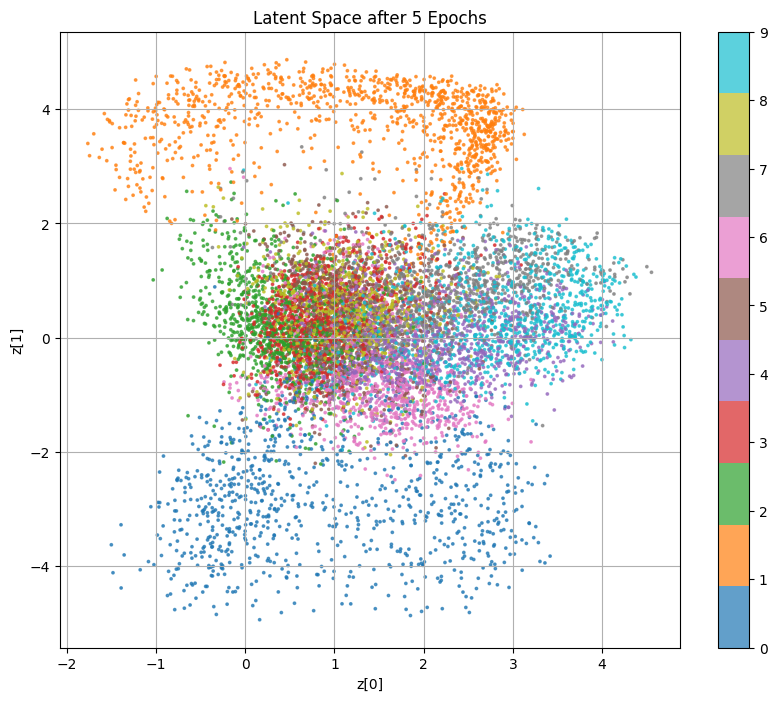

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

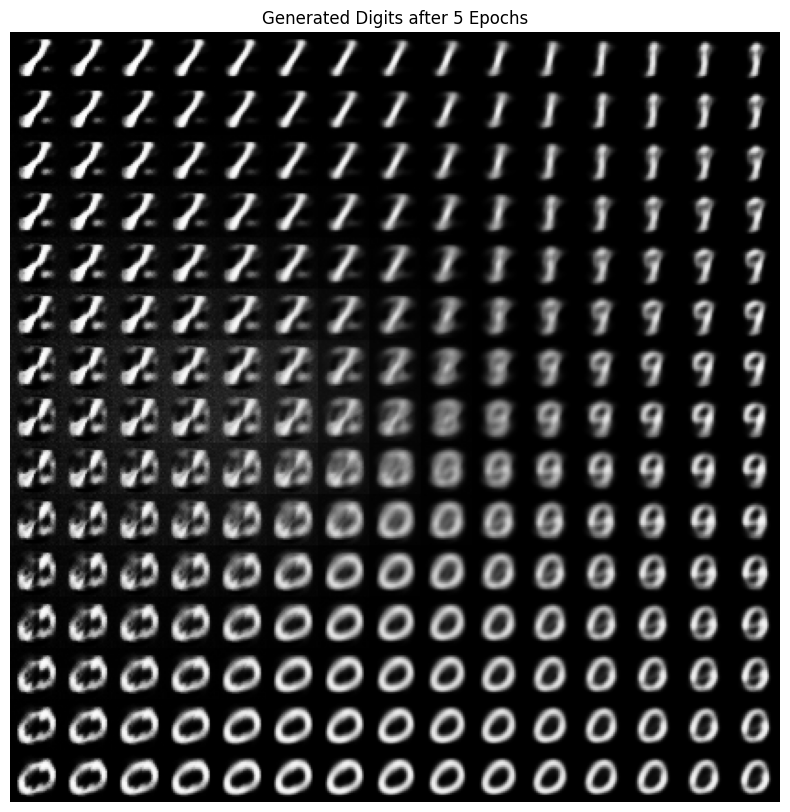


Training VAE for 15 epochs...
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 5.0751 - loss: 179.9554 - reconstruction_loss: 174.8802
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 4.7431 - loss: 176.2188 - reconstruction_loss: 171.4757
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 4.7294 - loss: 173.4601 - reconstruction_loss: 168.7307
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 4.7746 - loss: 171.6087 - reconstruction_loss: 166.8341
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 4.7884 - loss: 170.2018 - reconstruction_loss: 165.4134
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 4.7912 - loss: 169.3238 - reconstruction_loss: 164.5326
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 4.8054 - loss: 168.2181 - reconstruction_loss: 163.4127
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kl_loss: 4.8425 - loss: 167.4599 - reconstruction_loss: 162.6174
Epoch 9/15
469/46

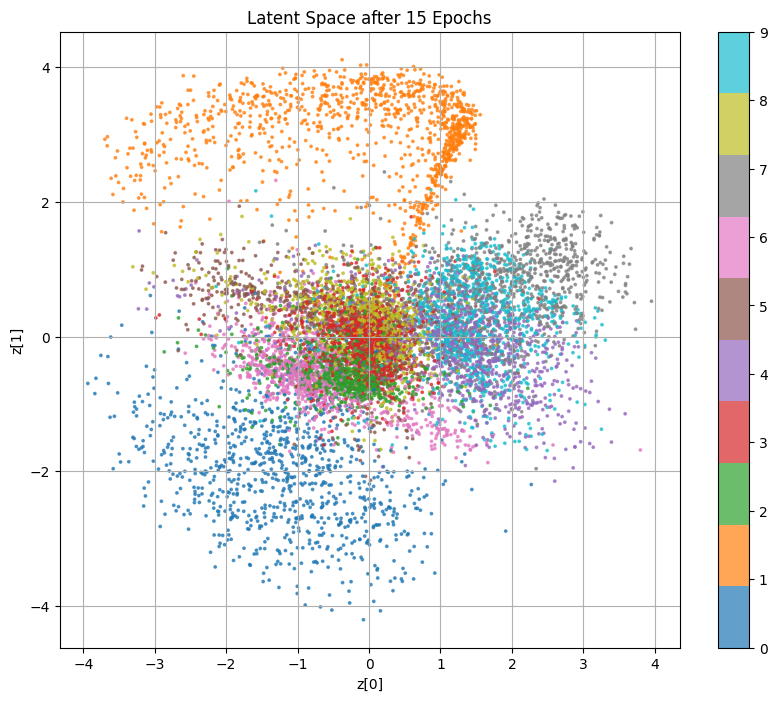

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

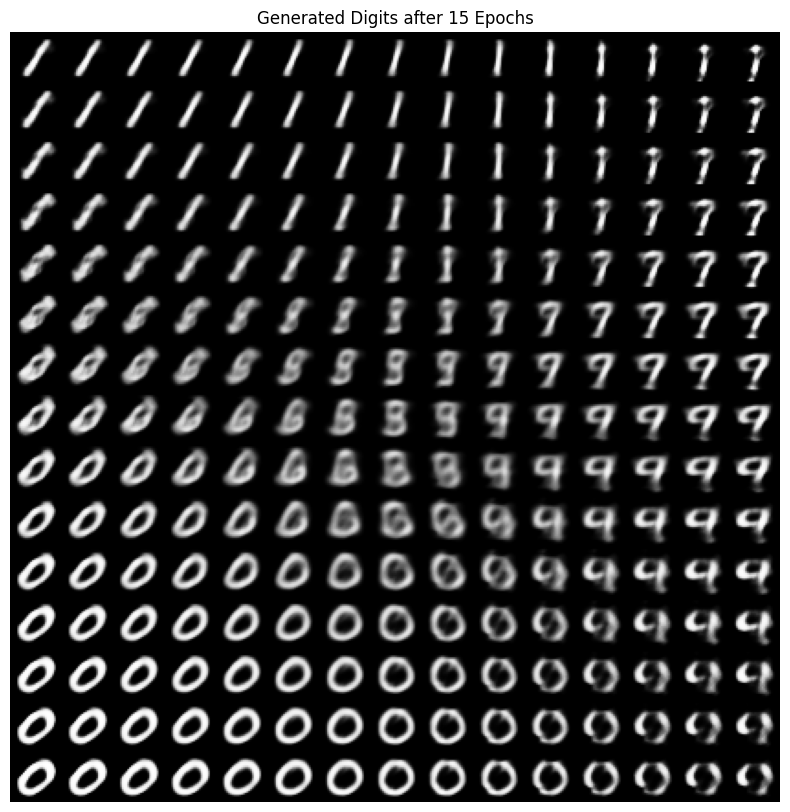


Training VAE for 30 epochs...
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 5.0268 - loss: 163.7570 - reconstruction_loss: 158.7301
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 5.0662 - loss: 163.1476 - reconstruction_loss: 158.0815
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kl_loss: 5.0758 - loss: 163.1587 - reconstruction_loss: 158.0830
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 5.1036 - loss: 162.6114 - reconstruction_loss: 157.5078
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 5.1343 - loss: 162.1799 - reconstruction_loss: 157.0456
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 5.1331 - loss: 161.9833 - reconstruction_loss: 156.8502
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 5.1386 - loss: 162.0644 - reconstruction_loss: 156.9258
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 5.1683 - loss: 162.0244 - reconstruction_loss: 156.8561
Epoch 9/30
469/46

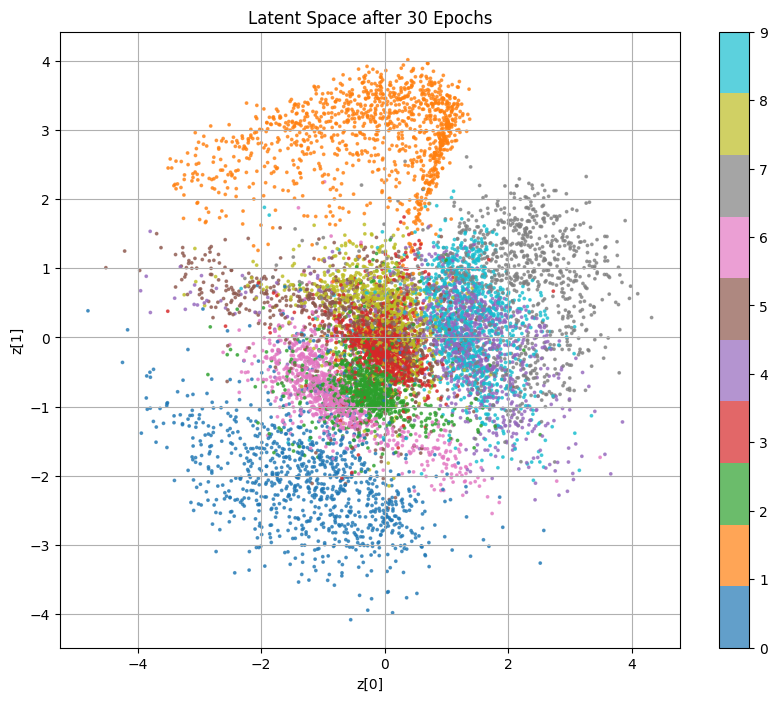

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

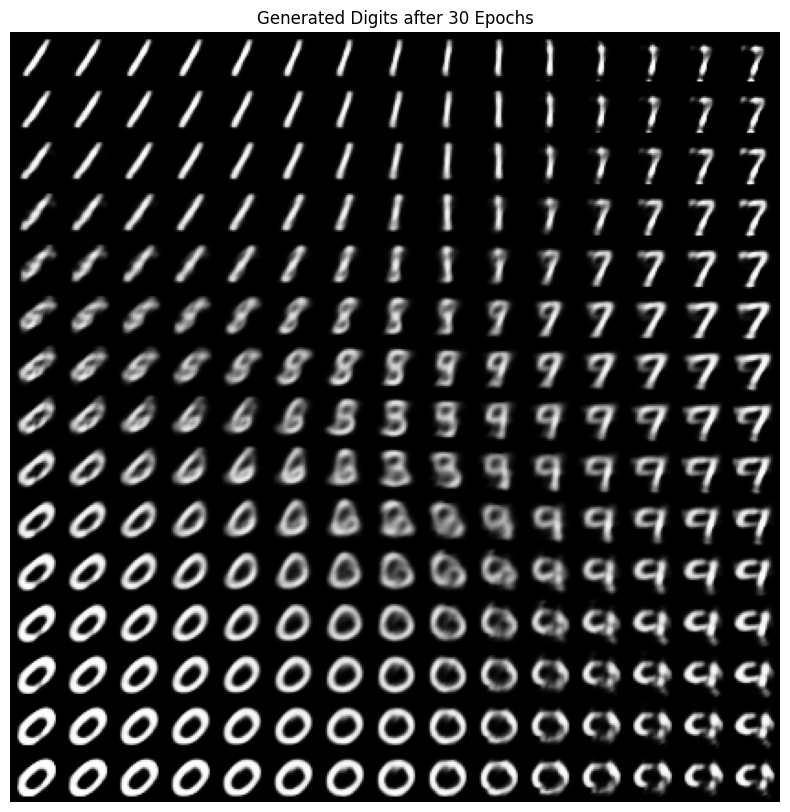

In [6]:
def train_vae_for_epochs(epochs):
    print(f"\nTraining VAE for {epochs} epochs...")
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
    vae.fit(x_train, epochs=epochs, batch_size=batch_size)
    plot_latent_space(encoder, x_test, y_test, f"Latent Space after {epochs} Epochs")
    generate_digits(decoder, title=f"Generated Digits after {epochs} Epochs")

# Run all three sessions
for e in [5, 15, 30]:
    train_vae_for_epochs(e)


**Question 1: Briefly describe how the latent space has changed with the number of epochs (Approx. 100 words)**

At 5 epochs, the latent space was highly entangled, with digits like ‘3’, ‘5’, and ‘8’ overlapping in a dense central cluster. The model had not yet learned to separate digit classes. By 15 epochs, some structuring began to emerge: digits such as ‘0’, ‘1’, and ‘6’ formed more compact groupings, although overlap was still common - for example, ‘4’ and ‘9’ were often mixed. At 30 epochs, the clusters became tighter for frequently seen digits like ‘0’, ‘1’, and ‘7’, showing improved but still partial separation. Less frequent or harder-to-distinguish digits like ‘2’ and ‘5’ remained intermixed with others.

**Question 2: Briefly describe how the quality of generated digits has changed with the number of epochs (Approx. 100 words)**

At 5 epochs, the generated digits were blurry and often unrecognizable, with many resembling incomplete strokes or generic vertical bars - for example, many samples resembled distorted versions of ‘1’ or ‘7’. By 15 epochs, accuracy improved: digits like ‘0’, ‘1’, and ‘8’ appeared clearer and more distinguishable. However, diversity remained limited - digits like ‘3’, ‘4’, and ‘2’ were rarely generated or poorly differentiated from ‘5’ or ‘9’. At 30 epochs, accuracy for digits like ‘0’ and ‘9’ was high, with clean loops and consistent shapes. Yet, the model still lacked variety, often generating repetitive digits, indicating mode collapse and limited generalization.

## Epochs = 50, 100


Training VAE for 50 epochs...
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - kl_loss: 5.5046 - loss: 157.0288 - reconstruction_loss: 151.5242
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 5.5071 - loss: 157.0300 - reconstruction_loss: 151.5228
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 5.5256 - loss: 156.6601 - reconstruction_loss: 151.1345
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kl_loss: 5.5476 - loss: 156.3959 - reconstruction_loss: 150.8483
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 5.5297 - loss: 156.5816 - reconstruction_loss: 151.0519
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 5.5737 - loss: 156.3714 - reconstruction_loss: 150.7977
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 5.5856 - loss: 156.2992 - reconstruction_loss: 150.7136
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 5.5880 - loss: 155.9839 - reconstruction_loss: 150.3959
Epoch 9/50
469/46

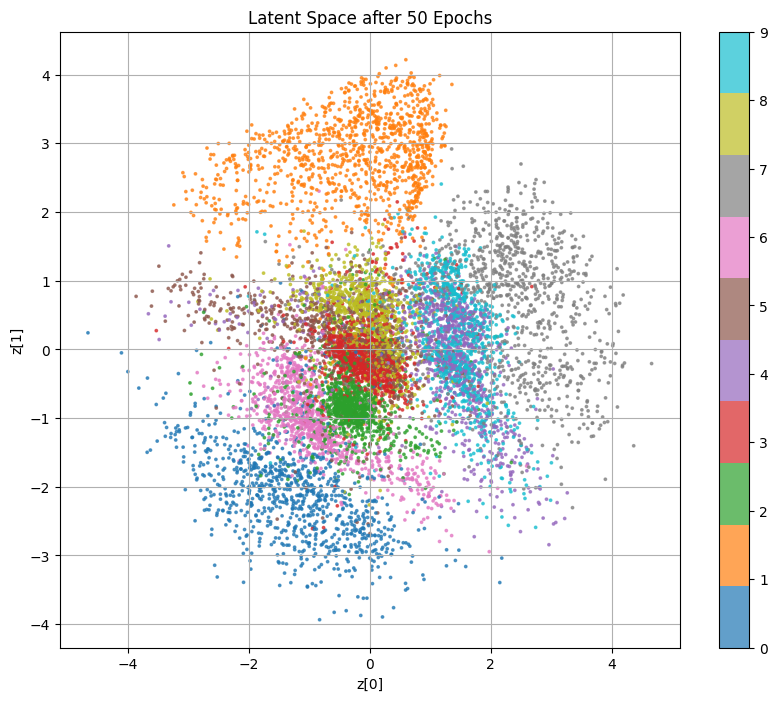

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

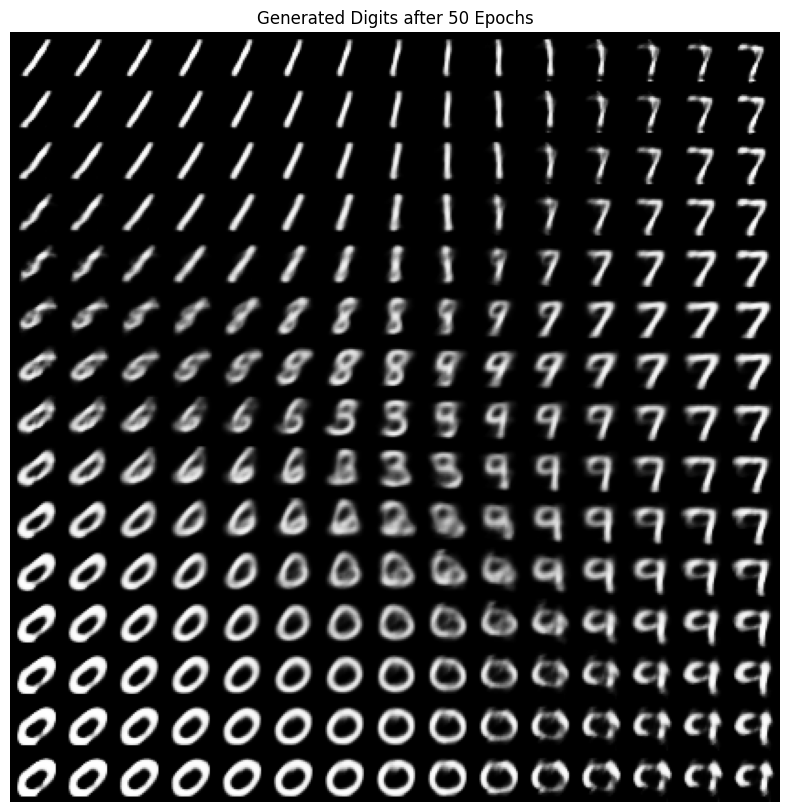


Training VAE for 100 epochs...
Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - kl_loss: 5.9048 - loss: 152.1048 - reconstruction_loss: 146.2001
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 5.9046 - loss: 152.2613 - reconstruction_loss: 146.3567
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 5.9012 - loss: 151.9277 - reconstruction_loss: 146.0265
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 5.9222 - loss: 152.0997 - reconstruction_loss: 146.1775
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 5.9380 - loss: 151.6101 - reconstruction_loss: 145.6721
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 5.9268 - loss: 151.4993 - reconstruction_loss: 145.5725
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 5.9317 - loss: 151.5227 - reconstruction_loss: 145.5910
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 5.9086 - loss: 151.8474 - reconstruction_loss: 145.9388
Epoch 9/

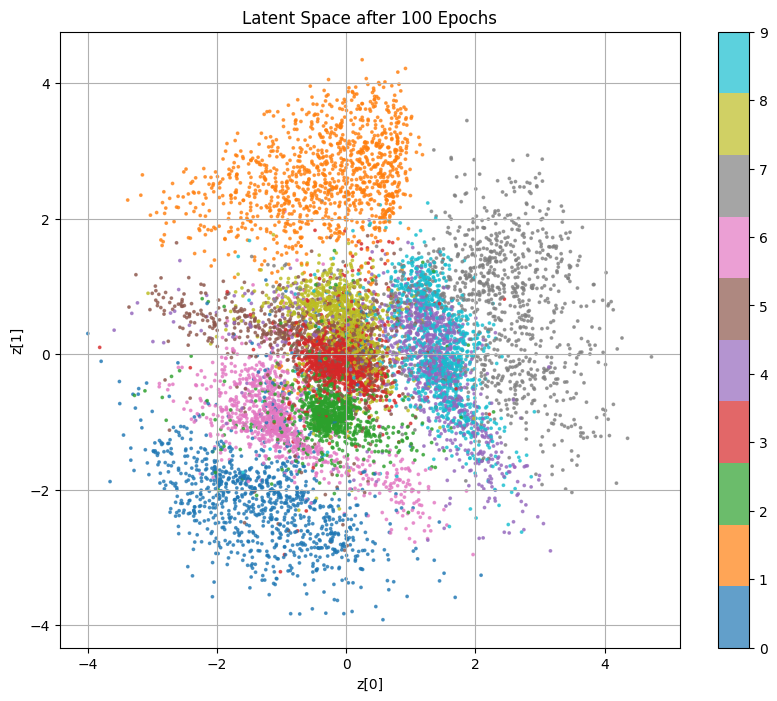

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

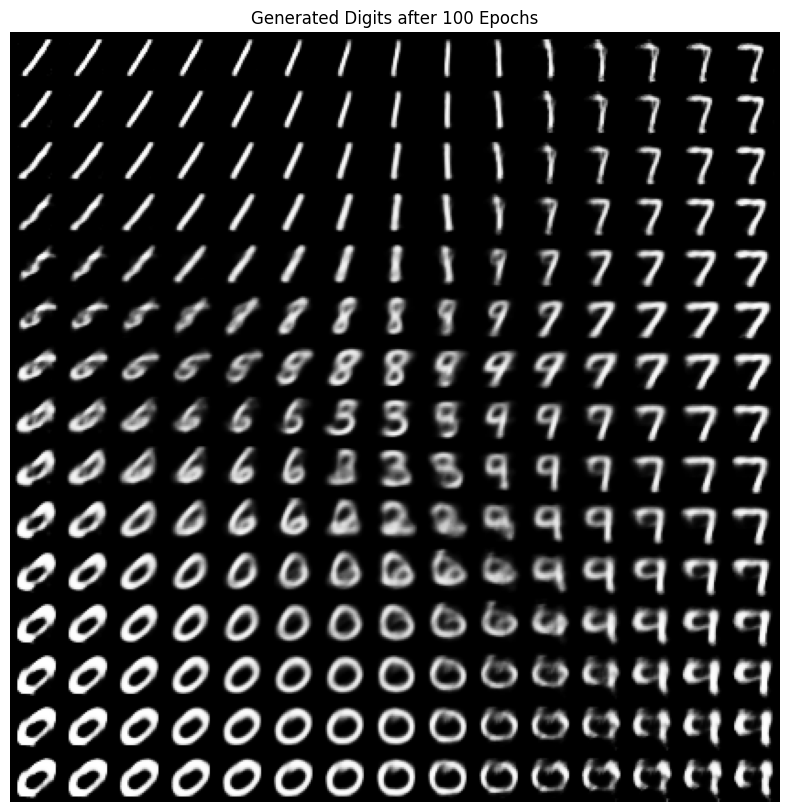

In [7]:
# Run all three sessions
for e in [50, 100]:
    train_vae_for_epochs(e)

**Question 3: What would happen if you try 50 or 100 epochs? Does the model get better or worse?**

Training the model for 50 and 100 epochs leads to improved digit clarity and greater reconstruction accuracy, particularly for digits the model was already learning well - such as ‘0’, ‘1’, ‘7’, and ‘9’. This improvement occurs because additional epochs give the model more time to minimize reconstruction loss and fine-tune its weights, allowing it to more confidently generate well-learned patterns. For example, by epoch 100, the loops in digits like ‘0’ and ‘9’ become smoother, and vertical strokes in digits like ‘1’ and ‘7’ appear more consistent and noise-free.

However, this improvement comes with trade-offs. The model starts to overfit to certain digit types that it sees more frequently or finds easier to reconstruct. As a result, less frequent or structurally complex digits like ‘3’, ‘4’, ‘6’, and ‘5’ are either poorly represented or completely missing from the generated grid. This phenomenon, known as mode collapse, reflects a narrowing of the model’s generative diversity - many latent vectors begin mapping to the same output classes, especially ‘1’ and ‘0’.

Moreover, the 2D latent space itself becomes a bottleneck. With limited capacity to encode complex variations among 10 digit classes, the model defaults to confidently producing high-frequency digits while ignoring nuanced representations of less common ones.

While clarity improves with extended training, overall performance worsens in terms of diversity and class differentiation. Thus, the model gets better in a narrow sense (accuracy of a few digits) but worse in its ability to represent the full MNIST dataset fairly and evenly.

